# Random Forest Classifier

In [62]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

import numpy as np
import pandas as pd

model = RandomForestClassifier(n_estimators=50, random_state=42, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=20)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
df = pd.read_csv('..\\data\\data.csv')

df = df[df['concentration'] > 0]

df = df.dropna(subset='wind_direction')

df.to_csv('..\\data\\data_cleaned.csv', index=False)




# Definisco le variabili feature
features = ['wind_direction', 'concentration', 'U', 'azimuth']
X = df[features]
# Definisco la variabile target
y = df['distance']



In [63]:
X

,wind_direction,concentration,U,azimuth
0,0.420,0.01380,2.17,52.0
1,0.420,0.03255,2.17,64.0
2,0.420,0.00460,2.17,64.0
3,0.420,0.03720,2.17,67.0
4,0.420,0.01380,2.17,67.0
...,...,...,...,...
2831,0.835,0.46060,4.07,127.5
2832,0.420,0.18800,4.07,129.0
2833,0.420,0.01692,4.07,129.0
2834,0.420,0.11233,4.07,130.5


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Faccio la cross-validation del modello
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
print("Cross-validation scores:", cv_scores)

trained_model = model.fit(X_train, y_train)
# Predizioni sul test set
y_test_pred = trained_model.predict(X_test)
# Valuto le prestazioni del modello
accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", accuracy)
print("Classification report:\n", classification_report(y_test, y_test_pred))

Cross-validation scores: [0.70044053 0.7092511  0.72246696 0.71365639 0.74008811 0.74449339
 0.66519824 0.72246696 0.75663717 0.71238938]
Test set accuracy: 0.7253521126760564
Classification report:
               precision    recall  f1-score   support

          50       0.80      0.84      0.82       234
         100       0.60      0.60      0.60       182
         200       0.75      0.70      0.72       152

    accuracy                           0.73       568
   macro avg       0.72      0.71      0.72       568
weighted avg       0.72      0.73      0.72       568



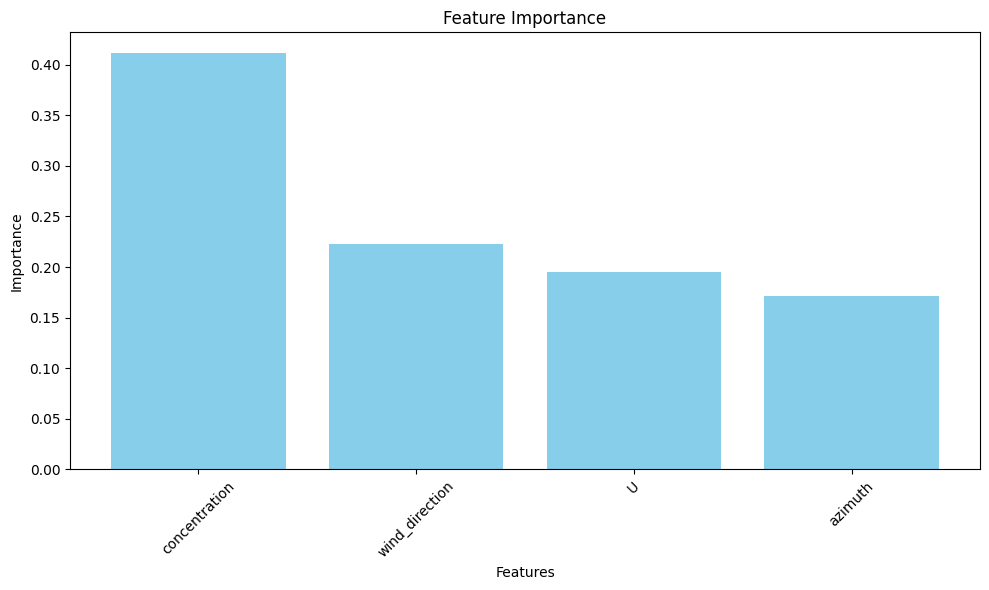

In [65]:


# Feature importance
importances = pd.DataFrame({
    'Feature': features,
    'Importance': trained_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
# Plotto le feature importance
plt.figure(figsize=(10, 6))
plt.bar(importances['Feature'], importances['Importance'], color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [66]:
# Metriche di valutazione
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Classification Report:")
print("Accuracy: ", accuracy_score(y_test, y_test_pred))


Classification Report:
Accuracy:  0.7253521126760564


In [67]:
# Predizione su nuovi dati
def predict_distance( wind_direction, concentration, Wind_Speed, azimuth_degrees):
    new_sample = pd.DataFrame([[ wind_direction, concentration, Wind_Speed, azimuth_degrees]], columns=features)
    prediction = trained_model.predict(new_sample)[0]
    probabilities = trained_model.predict_proba(new_sample)[0]
    print(f"Predicted distance: {prediction} metri")
    print(f"Probabilities per classe:")
    for i, prob in enumerate(probabilities):
        print(f"Classe {i} m: {prob:.2f}")
    return prediction

In [68]:
# Esempio di predizione
predict_distance( wind_direction=45, concentration=5, Wind_Speed=10, azimuth_degrees=60)


Predicted distance: 50 metri
Probabilities per classe:
Classe 0 m: 0.54
Classe 1 m: 0.43
Classe 2 m: 0.03


np.int64(50)

In [69]:
# Ottimizzazione del modello
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],

}

grid_search = GridSearchCV(estimator=trained_model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score:  0.7372246696035243
